In [5]:
import numpy as np
import pandas as pd
import os
import scipy
from scipy import interpolate, sparse
from scipy.sparse.linalg import spsolve
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline
from scipy.signal import medfilt

import os
import matplotlib.pyplot as plt

from bokeh.models import ColumnDataSource
from bokeh.models.sources import DataSource
from bokeh.io import output_notebook, show, export_png, export_svgs#, get_screenshot_as_png
from bokeh.plotting import figure
from bokeh.layouts import gridplot

In [6]:
output_notebook()

Loading BokehJS ...

# Choose your files to normalize

In order to merge the EC and the DEMS in a single file with a single time/potential scale you need to define:
* the input files of the EC data
* the input files of the DEMS data
* the masses recorded with DEMS

The parent directory of the datafiles should also be chosen as well as the outputfolder of the files. These are supposed to be set only once and won't change the next time you run the programm.

The data and output filenmes are created outomatically based on the input parameters (file/folder names)

In [1]:
# EC Files 
ec_file = ['20160119-Pt550-Ru(0001)A_COOx_step2_exp2.csv']

#DEMS File
dems_file = ['20160119-Pt550-Ru(0001)A_DEMS_COOx_step2_exp2.csv']

#masses
masses = [44]
# masses = [2, 44] # mostly used for BCV and ORR studies

### -------------! -------------Change only once (if necessary)
# Data folders:
workingdir = r'..\data'
ec_folder = r'..\data\EC_data'
dems_folder = r'..\data\DEMS_data' 

#outputfolder
outputfolder = r'..\data\EC_DEMS_data'

# --------- Auto genartion from here on 
# date is extracted from filename (This only works when the date is part of the beginning of the original filename)
date = dems_file[0][0:8]

# outputfilename
outputfilename =  dems_file[0][:8] + '_DEMS_CV_' + dems_file[0][9:]
output_fullname = outputfolder + '\\' + date + '\\' + outputfilename
output_fullname

'..\\data\\EC_DEMS_data\\20160119\\20160119_DEMS_CV_Pt550-Ru(0001)A_DEMS_COOx_step2_exp2.csv'

# Some required functions 

In [2]:
def get_all_filenames(folder, endswith='.csv'):
    '''Creates a list of files with full path of
    the selected folder and subfolders. Standard file type is csv.
    For other files specifiy endswith='.XXX'
    endswith is a string which has to include the dot.'''
    #os.path.join(root, file) combines the root folder name with the filename. As a result you get a full path of the file.
    #For filenames only file
    return [os.path.join(root, file) for root, dirs, files in os.walk(folder) for file in files if file.endswith(endswith)]

def file_list_full_path(filenames, allfiles):
    '''filenames is a list of filenames located 
    somewhere in the folder or its subfolders.
    The function creates a list with the full path of the filenames'''
    return [file for item in filenames for file in allfiles if item in file]

#------------------------------------------!---------------------------
## Probably not required in this programm
#choose this if you want to plot current 1 as is
def create_df_list_(file_list):
    '''Creates a list of dataframes from a list fo files with full path.'''
    return [pd.read_csv(items) for items in file_list]

#choose this to change current from A to muA
def create_EC_df_list(file_list):
    '''Creates a list of dataframes from a list fo files with full path.'''
    df_list = []
    for items in file_list:
        df = pd.read_csv(items)
        #df['current1'] = df['current1']
        df_list.append(df)
    return df_list

def create_DEMS_df_list(file_list):
    '''Creates a list of dataframes from a list fo files with full path.'''
    df_list = []
    for items in file_list:
        df = pd.read_csv(items)
        df_list.append(df)
    return df_list


def get_filenames_in_folder(folder):
    folder_content = os.listdir(folder)
    return [item for item in folder_content if 'csv' in item]

## Auto generate the full path of input and output files

In [53]:
allfiles = get_all_filenames(workingdir)
ec_fullname = file_list_full_path(ec_file, allfiles)
dems_fullname = file_list_full_path(dems_file, allfiles)

print('EC File: ' + ec_fullname[0])
print('DEMS File: ' + dems_fullname[0])
print('Outputfilename: ' + output_fullname)

EC File: ..\data\EC_data\20160119\20160119-Pt550-Ru(0001)A_COOx_step2_exp2.csv
DEMS File: ..\data\DEMS_data\20160119\20160119-Pt550-Ru(0001)A_DEMS_COOx_step2_exp2.csv
Outputfilename: ..\data\EC_DEMS_data\20160119\20160119_DEMS_CV_Pt550-Ru(0001)A_DEMS_COOx_step2_exp2.csv


## Import the files as dataframes

In [54]:
ecData = create_EC_df_list(ec_fullname)[0]
demsData = create_DEMS_df_list(dems_fullname)[0]

EC file structure

In [55]:
ecData.head()

,potential,current1,time,current1_muA
0,0.200458,-1.020000e-07,1.779974,-0.1020
1,0.199368,-8.640000e-08,1.879974,-0.0864
2,0.197962,-1.130000e-07,1.979974,-0.1130
3,0.196093,-8.310000e-08,2.180000,-0.0831
4,0.195162,-5.340000e-08,2.280000,-0.0534


DEMS file structure

In [56]:
demsData.head()

,time_rel_M44,ion_current_M44,time_absolute_m44
0,0.000,4.440000e-10,0.000
1,0.091,4.440000e-10,0.091
2,0.182,4.480000e-10,0.182
3,0.273,4.450000e-10,0.273
4,0.363,4.440000e-10,0.363


# Problems of file structure and solution
As you can see we have two files (for EC and DEMS), where each file has its indvidual timescale. In additon in the DEMS file, each mass has its own timescale.  
Two problems will be addressed in the following lines of code:
1. We adjust the timeshift between the EC and DEMS file by manual adjusting a peak in the CV with a know mass observed in that peak during MS
2. We merge all timescales on one axis, in order to obtain a single dataframe including:
 * time
 * potential
 * WE current
 * Currents of all measured masses

In [57]:
915.496-933.502

-18.005999999999972

In [58]:
TimeIndexFactor = -5
# Probably it would be better to look up a real value with the index weher the time is located

#normalize by which mass
mass = masses[0] # 0 = first mass in list fo masses, 1 is second, etc

# create new dataframe and interactive plot
for i in range(len(masses)):
    demsData['time_rel_norm_M' + str(masses[i])] = demsData['time_rel_M' + str(masses[i])] + TimeIndexFactor

plot_options = dict(width=800, plot_height=300, tools='pan,box_zoom,wheel_zoom,box_select,lasso_select,hover,help,undo,redo,save,reset')
p1 = figure(**plot_options)
p1.line(x = ecData['time'] , y = ecData['current1'])
p1.yaxis.axis_label = "Current / muA"

p2 = figure(x_range = p1.x_range, **plot_options)
p2.line(x = ecData['time'], y = ecData['potential'])
p2.yaxis.axis_label = "Potential / U"

p3 = figure(x_range = p1.x_range, y_axis_type="log", **plot_options)
p3.line(x = demsData['time_rel_norm_M' + str(mass)], y = demsData['ion_current_M' + str(mass)])
p3.yaxis.axis_label = "Ion count / a.u."
p3.xaxis.axis_label = "time / s"

# The following lines would allow for showing the CV
#p4 = figure(**plot_options)
#p4.line(x = datavoltage, y = datacurrent)
p = gridplot([[p1], [p2], [p3]], toolbar_location='right')
show(p)

# Create dataframe without negative values

In [59]:
demsData.dtypes

time_rel_M44         float64
ion_current_M44      float64
time_absolute_m44    float64
time_rel_norm_M44    float64
dtype: object

Adjusting the timeshift causes one of the two timescales (Dems or EC data) to have negative values. These are no longer relevant and will be removed from the dataset

In [60]:
#remove all all rows with negative time values
demsData_time_norm = demsData[demsData['time_rel_norm_M44'] > 0].dropna().reset_index(drop=True)  #['time_rel_norm_M2']
#Determine maximum time on last mass
tmax = demsData_time_norm['time_rel_norm_M' + str(masses[-1])].max()
demsData_time_norm.head()

,time_rel_M44,ion_current_M44,time_absolute_m44,time_rel_norm_M44
0,5.087,4.450000e-10,5.087,0.087
1,5.178,4.410000e-10,5.178,0.178
2,5.269,4.420000e-10,5.269,0.269
3,5.360,4.430000e-10,5.360,0.360
4,5.451,4.440000e-10,5.451,0.451


In [61]:
demsData_time_norm.dtypes

time_rel_M44         float64
ion_current_M44      float64
time_absolute_m44    float64
time_rel_norm_M44    float64
dtype: object

# Merge all masses on one time axis
For convenience we merge all masses on a single timescale. Therfore we interpolate over all datapoints and determine the mass currents at sepcific times.  
The interval can be modified at the beginning of the following cell. Standard is 0.05, which means we create a file where the datapoints are located every 0.05 s.  
The normalized datastructure are shown

In [62]:
timeinterval = 0.05 # time interval of the interpolation

t_relative = np.arange(0, tmax, timeinterval) #minimum time, maximum time of last mass, time interval of the interpolation

df_norm = pd.DataFrame(t_relative, columns=['time']).set_index('time')

for i in range(len(masses)):
        df_interpol = interpolate.interp1d(demsData_time_norm['time_rel_norm_M' + str(masses[i])], demsData_time_norm['ion_current_M' + str(masses[i])], 
                                           bounds_error=False, fill_value='extrapolate')
        df_norm['ion_current_M' + str(masses[i])] = df_interpol(t_relative)
        
df_norm.head()

,ion_current_M44
time,
0.00,4.488242e-10
0.05,4.466264e-10
0.10,4.444286e-10
0.15,4.422308e-10
0.20,4.412418e-10


# interpolate the voltage and potential on the same relative time axis
Next we interpolate with the identical new timescale our EC data and merge the DEMS and EC file into a single file.   
We do this for all columns in the EC dataframe containing 'potential' or 'current' (current1, coll_current, etc) values.  
We show which columns have been created an show the filestructure of the merged data

In [63]:
colnames = []

for colname in list(ecData):
    if 'potential' in colname:
        colnames.append(colname)
    if 'current' in colname:
        colnames.append(colname)

for colname in colnames:
    print(colname)
    interpol_df = interpolate.interp1d(ecData['time'], ecData[colname], bounds_error=False, fill_value='extrapolate')
    df_norm[colname] = interpol_df(t_relative)
    
df_ecdems = df_norm.reset_index(drop=False)
df_ecdems.head()


potential
current1
current1_muA


,time,ion_current_M44,potential,current1,current1_muA
0,0.00,4.488242e-10,0.219865,-3.796759e-07,-0.379676
1,0.05,4.466264e-10,0.219320,-3.718759e-07,-0.371876
2,0.10,4.444286e-10,0.218775,-3.640759e-07,-0.364076
3,0.15,4.422308e-10,0.218229,-3.562759e-07,-0.356276
4,0.20,4.412418e-10,0.217684,-3.484759e-07,-0.348476


# Removing undesired data
Each measurement contains at the beginning and/or end some useless data resulting from the different times both measurements were started/stopped. These can be determined graphically and finally removed manually by setting manually a cutoff at the lower_limit and upper_limit of all data.  
Note: in general it is sufficient to look at the data on the potential scale.

In [64]:
#lower_limit = 0
#upper_limit = 15000

lower_limit = 0
upper_limit = 11672
df_co = df_ecdems.iloc[lower_limit:upper_limit].copy()

plot_options = dict(width=800, plot_height=400, tools='pan,box_zoom,wheel_zoom,box_select,lasso_select,hover,help,undo,redo,save,reset')
p5 = figure(**plot_options)
p5.line(x=df_co['time'] , y = df_co['potential'])
p5.line(x=df_co['time'] , y = df_co['current1_muA'], color='red')
p5.yaxis.axis_label = "Current / muA"
show(p5)
#df_ecdems.iloc[lower_limit:upper_limit].to_csv(output_fullname, index=False) ##<----- Can save file at this point

# Check the quality of your timescale adjustment

In the next cell you can check if your timeshift is adjusted correctly. If this is not the case, restart in the cell where you change the timeshift

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


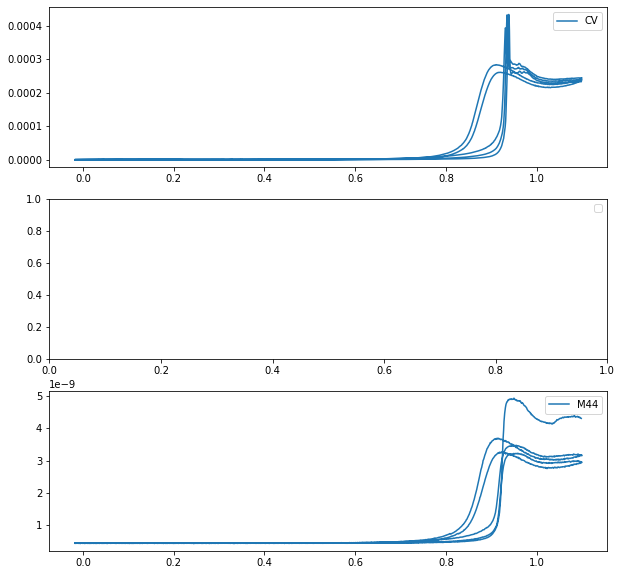

In [65]:
f, ax = plt.subplots(3,1, figsize=(10,10))
lowlim = 0
uplim = -1
ax[0].plot(df_co['potential'][lowlim:uplim], df_co['current1'][lowlim:uplim], label='CV')
#ax[1].plot(df_co['potential'][lowlim:uplim], df_co['ion_current_M2'][lowlim:uplim], label='M2')
ax[2].plot(df_co['potential'][lowlim:uplim], df_co['ion_current_M44'][lowlim:uplim], label='M44')

for i, label in enumerate(ax):
    ax[i].legend()
#ax[1].set_ylim(0, 0.2E-8)
#ax[1].set_xlim(-0.250, 1)

# Baseline correction

As you can see from the above data, the background of the mass signals is not perfectly flat and changes in course of time (Shown again the cell below.   
In the following cells we determine the background of the meaurement and remove it from the data to get a background subtracted signal.

Select mass:

In [66]:
mass = masses[0]
print(f'Selected mass is: {mass}')

Selected mass is: 44


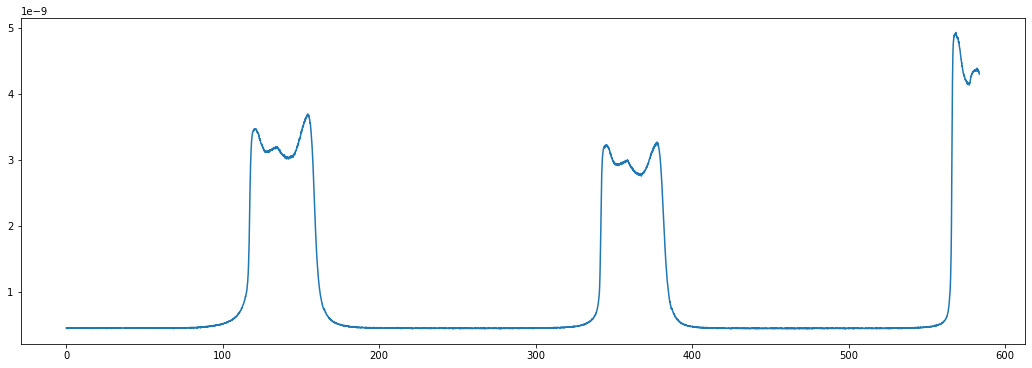

In [67]:
df_co = df_co.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df_co['time'], df_co[f'ion_current_M{mass}'])

Function required for baseline subtraction

In [68]:
def baseline_als(y, lam, p, niter=10):                                                                        

    s  = len(y)                                                                                               
    # assemble difference matrix                                                                              
    D0 = sparse.eye( s )                                                                                      
    d1 = [np.ones( s-1 ) * -2]                                                                             
    D1 = sparse.diags( d1, [-1] )                                                                             
    d2 = [np.ones( s-2 ) * 1]                                                                             
    D2 = sparse.diags( d2, [-2] )                                                                             

    D  = D0 + D2 + D1                                                                                         
    w  = np.ones( s )                                                                                         
    for i in range( niter ):                                                                                  
        W = sparse.diags( [w], [0] )                                                                          
        Z =  W + lam*D.dot( D.transpose() )                                                                   
        z = spsolve( Z, w*y )                                                                                 
        w = p * (y > z) + (1-p) * (y < z)   
    
    return z

## Adjusting BL subtraction parameters
In the next cell you can adjust a number of parameters to subtract the Background from the signal.
A detailed description of the individual methods will be provided elsewhere.

In [69]:
#Medfilt = 151 # needs to be odd
# ALS good starting point is 1E8, 1E-6, niter=2

Text(0.5, 0, 'time / s')

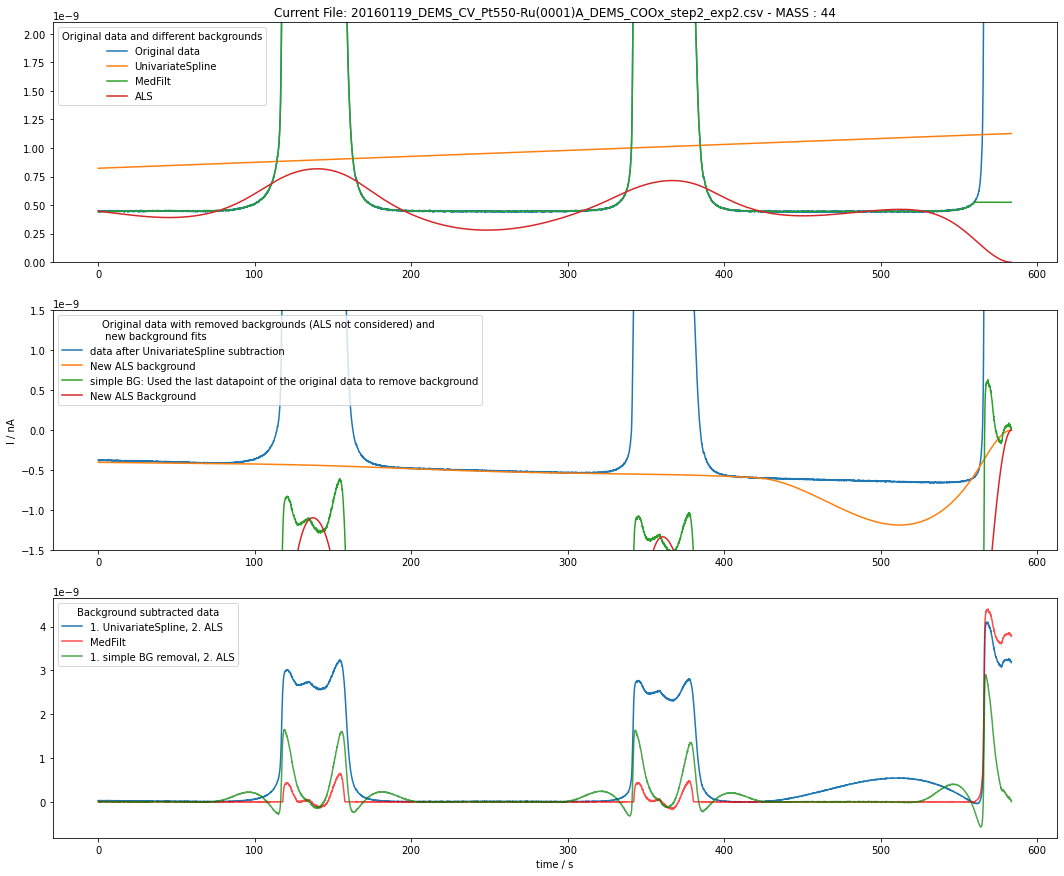

In [70]:
# Method 1 - First remove the last datapoint as background and apply ALS
df_co[f'ion_current_M{mass}_sBG_sub'] = df_co[f'ion_current_M{mass}'] - df_co[f'ion_current_M{mass}'].iloc[-1]
# df_co[f'ion_current_M{mass}_sBG_ALS'] = baseline_als(df_co[f'ion_current_M{mass}_sBG_sub'], 1E11, 1E-6, niter=5) # 1E8, 1E-6, iter=2
df_co[f'ion_current_M{mass}_sBG_ALS'] = baseline_als(df_co[f'ion_current_M{mass}_sBG_sub'], 1E8, 1E-6, niter=2) # 1E8, 1E-6, iter=2
df_co[f'ion_current_M{mass}_sBG_ALS_sub'] = df_co[f'ion_current_M{mass}_sBG_sub'] - df_co[f'ion_current_M{mass}_sBG_ALS']

# Method 2 - ALS on original data. Not working because data too far from 0 on the y axis
df_co[f'ion_current_M{mass}_ALS'] = baseline_als(df_co[f'ion_current_M{mass}'], 1E10, 1E-6, niter=2)
#df_co['M2_smoothed'] = baseline_als(df_co['ion_current_M2'], 100, 0.001, niter=1)

# Method 3 - Apply Univariate Spline and then ALS
sp2 = UnivariateSpline(df_co['time'], df_co[f'ion_current_M{mass}'], k=1, s=0.1) #k=5, s=0.1) s=200
#sp2 = LSQUnivariateSpline(demsData2['time_rel_M2'], demsData2['ion_current_M2'], t) # A variante of univariate spline for testing purpose
df_co[f'ion_current_M{mass}_UVS'] = sp2(df_co['time'])
df_co[f'ion_current_M{mass}_UVS_sub'] = df_co[f'ion_current_M{mass}'] - df_co[f'ion_current_M{mass}_UVS']
## ALS
df_co[f'ion_current_M{mass}_UVS_ALS'] = baseline_als(df_co[f'ion_current_M{mass}_UVS_sub'], 1E8, 1E-6, niter=15) # 1E8, 1E-6, iter=2
df_co[f'ion_current_M{mass}_UVS_ALS_sub'] = df_co[f'ion_current_M{mass}_UVS_sub'] - df_co[f'ion_current_M{mass}_UVS_ALS']

#Method 4 - Apply MedFilt and tgen ALS
MF_steps = 951 #uneven number
df_co[f'ion_current_M{mass}_MF'] = medfilt(df_co[f'ion_current_M{mass}'], MF_steps) # number should be large in comparison to your peak X-axis lengths and an odd number.
df_co[f'ion_current_M{mass}_MF_sub'] = df_co[f'ion_current_M{mass}'] - df_co[f'ion_current_M{mass}_MF']

# Plotting
cutoff = -1
fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15))

ax.plot(df_co['time'], df_co[f'ion_current_M{mass}'], label='Original data')
ax.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_UVS'][:cutoff], label='UnivariateSpline')
ax.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_MF'][:cutoff], label='MedFilt')
ax.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_ALS'][:cutoff], label='ALS')
ax.set_ylim(0E-8,0.21E-8)

#ax.set_ylim(df_co[f'ion_current_M{mass}'].iloc[-1] - df_co[f'ion_current_M{mass}'].iloc[-1]*0.1,
#            df_co[f'ion_current_M{mass}'].iloc[-1]*0.1 + df_co[f'ion_current_M{mass}'].iloc[-1])
ax.legend(title='Original data and different backgrounds')
ax.set_title(f'Current File: {outputfilename} - MASS : {mass}')

ax2.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_UVS_sub'][:cutoff], label='data after UnivariateSpline subtraction')
ax2.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_UVS_ALS'][:cutoff], label='New ALS background')
ax2.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_sBG_sub'][:cutoff], label='simple BG: Used the last datapoint of the original data to remove background')
ax2.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_sBG_ALS'][:cutoff], label='New ALS Background')
ax2.legend(title='Original data with removed backgrounds (ALS not considered) and \n new background fits')
ax2.set_ylabel('I / nA')
ax2.set_ylim(-0.15E-8,0.15E-8)
#ax2.set_ylim(-1.5E-11,0.25E-10)
#ax2.set_xlim(1700,2000)

ax3.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_UVS_ALS_sub'][:cutoff],label='1. UnivariateSpline, 2. ALS')
ax3.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_MF_sub'][:cutoff],label='MedFilt', color='red', alpha=0.7)
ax3.plot(df_co['time'][:cutoff], df_co[f'ion_current_M{mass}_sBG_ALS_sub'][:cutoff],label='1. simple BG removal, 2. ALS', color='green', alpha=0.7)
ax3.legend(title='Background subtracted data')
ax3.set_xlabel('time / s')
#ax3.set_ylim(-0.5E-10,0.5E-10)
#fig.set_title(outputfilename)
#ax.set_ylim(0.9E-8, 1.1E-8)

# Final  File structure
The final file contains now all values required for durther data evaluation and presentation, such as peak integration, etc..

In [71]:
df_co.head()

,time,ion_current_M44,potential,current1,current1_muA,ion_current_M44_sBG_sub,ion_current_M44_sBG_ALS,ion_current_M44_sBG_ALS_sub,ion_current_M44_ALS,ion_current_M44_UVS,ion_current_M44_UVS_sub,ion_current_M44_UVS_ALS,ion_current_M44_UVS_ALS_sub,ion_current_M44_MF,ion_current_M44_MF_sub
0,0.00,4.488242e-10,0.219865,-3.796759e-07,-0.379676,-3.850956e-09,-3.855442e-09,4.486015e-12,4.469997e-10,8.228024e-10,-3.739782e-10,-4.032609e-10,2.928264e-11,4.403077e-10,8.516484e-12
1,0.05,4.466264e-10,0.219320,-3.718759e-07,-0.371876,-3.853154e-09,-3.855438e-09,2.283876e-12,4.469159e-10,8.228285e-10,-3.762021e-10,-4.032706e-10,2.706855e-11,4.412418e-10,5.384615e-12
2,0.10,4.444286e-10,0.218775,-3.640759e-07,-0.364076,-3.855352e-09,-3.855433e-09,8.173743e-14,4.468321e-10,8.228545e-10,-3.784260e-10,-4.032804e-10,2.485445e-11,4.413187e-10,3.109890e-12
3,0.15,4.422308e-10,0.218229,-3.562759e-07,-0.356276,-3.857549e-09,-3.855429e-09,-2.120401e-12,4.467482e-10,8.228806e-10,-3.806498e-10,-4.032902e-10,2.264035e-11,4.413956e-10,8.351648e-13
4,0.20,4.412418e-10,0.217684,-3.484759e-07,-0.348476,-3.858538e-09,-3.855425e-09,-3.113749e-12,4.466644e-10,8.229067e-10,-3.816649e-10,-4.032999e-10,2.163504e-11,4.417253e-10,-4.835165e-13


if you prefer the original data, simply overwrite or remove the undesired columns

In [72]:
# df_co['ion_current_M44_UVS_ALS_sub'] = df_co['ion_current_M44']

In [75]:
df_co.head(2)

,time,ion_current_M44,potential,current1,current1_muA,ion_current_M44_sBG_sub,ion_current_M44_sBG_ALS,ion_current_M44_sBG_ALS_sub,ion_current_M44_ALS,ion_current_M44_UVS,ion_current_M44_UVS_sub,ion_current_M44_UVS_ALS,ion_current_M44_UVS_ALS_sub,ion_current_M44_MF,ion_current_M44_MF_sub
0,0.00,4.488242e-10,0.219865,-3.796759e-07,-0.379676,-3.850956e-09,-3.855442e-09,4.486015e-12,4.469997e-10,8.228024e-10,-3.739782e-10,-4.032609e-10,4.488242e-10,4.403077e-10,8.516484e-12
1,0.05,4.466264e-10,0.219320,-3.718759e-07,-0.371876,-3.853154e-09,-3.855438e-09,2.283876e-12,4.469159e-10,8.228285e-10,-3.762021e-10,-4.032706e-10,4.466264e-10,4.412418e-10,5.384615e-12


# Saving the File
Finally save this into a useful format (e.g., CSV)  
Use this file in other programs

In [74]:
if not os.path.isdir(outputfolder +  '\\' + date):
            os.makedirs(outputfolder +  '\\' + date)
df_co.to_csv(output_fullname,index=False)

# Outlook

The file we created here can now be processed by another programm which automatically splits the file into forward, backward and full scan cyclic voltamograms. These small files always contain all the values that we created in this file, thus you can plot anything vs. anything. In addition you can continue to evaluate some CVs in more detail and higher accuracy compared to this full scan approach.